## Preprocessing of imaging data
### Load, parse metadata and generate data object

In [1]:
from ScanImageTiffReader import ScanImageTiffReader
import json
from matplotlib import pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as ppatch
import numpy as np

#from sys import path
from os.path import sep, exists
from os import mkdir, makedirs, getcwd

import napari

#for roi generation
import shapely as sp
from shapely.geometry.polygon import LinearRing, Polygon, LineString

In [2]:
from fly2p.viz.viz import myAxisTheme

import fly2p.preproc.imgPreproc as imp

%gui qt5
%config Completer.use_jedi = False  #magic to fix autocomplete issue

### Set paths to data files and plot directory

In [3]:
rootDir = '../../../../data_unityvr'
dataDir = sep.join([rootDir, 'raw/Drep2test/57C10_x_6fDrep2/BU/f01'])
rawTiff = '57C10-x-6fDrep2_f01_4-6d_BU_sunSpot_00001.tif'
plotDir = sep.join([rootDir, 'plot', sep.join(dataDir.split(sep)[-4:])])
preprocDir = sep.join([rootDir, 'preproc', sep.join(dataDir.split(sep)[-4:])])

print(dataDir)
print(plotDir)

../../../../data_unityvr/raw/Drep2test/57C10_x_6fDrep2/BU/f01
../../../../data_unityvr/plot/Drep2test/57C10_x_6fDrep2/BU/f01


In [4]:
genotype = rawTiff.split('_')[0]
[flyID, age, region] = rawTiff.split('_')[1:4]
condition = rawTiff.split('_')[-2]
trial = rawTiff.split('_')[-1][:-4]
print(genotype, region, flyID, age, condition, trial)

57C10-x-6fDrep2 BU f01 4-6d sunSpot 00001


In [5]:
# Generate directory where to save plots
saveDir = sep.join([plotDir, condition])
if not exists(saveDir):
    makedirs(saveDir)
print(saveDir)

../../../../data_unityvr/plot/Drep2test/57C10_x_6fDrep2/BU/f01/sunSpot


### Load tiff file

#### Extract relevant information from header

In [6]:
from fly2p.preproc.scanImageUtils import getSIbasicMetadata, getSIMetadict

In [7]:
#with ScanImageTiffReader("data/resj_00001.tif") as reader:
mytiffreader = ScanImageTiffReader(sep.join([dataDir, rawTiff]))

metadat = mytiffreader.metadata()

basicMetadat = getSIbasicMetadata(metadat)

# give channel identity
basicMetadat["CaCh"] = 0
SImetadict = getSIMetadict(metadat)

#print(mytiffreader.metadata())

basicMetadat

SI.VERSION_COMMIT = '4a9264c4fccd21a03258704d0d6489537ad79e6c'
SI.VERSION_MAJOR = '2018b'
SI.VERSION_MINOR = '1'


{'nCh': 1,
 'fpsscan': 50.1735,
 'discardFBFrames': 'true',
 'nDiscardFBFrames': 2,
 'fpv': 10,
 'nVols': 1506,
 'stackZStepSize': 4,
 'scanVolumeRate': 5.01735,
 'fovCoords': {'p00': [-10.125, -10.125],
  'p10': [10.125, 10.125],
  'p01': [10.125, -10.125],
  'p11': [-10.125, 10.125]},
 'xrange_um': 20.25,
 'yrange_um': 20.25,
 'CaCh': 0}

#### Read and reshape image tiff stack

In [8]:
vol = mytiffreader.data()
volshape = vol.shape
print(volshape)

vol = vol.reshape((int(volshape[0]/(basicMetadat['fpv']*basicMetadat['nCh'])),
                   basicMetadat['fpv'],basicMetadat['nCh'],volshape[1], volshape[2]))

print('Full dimensional stack: volumes, planes, channels, xpix, ypix')
print(vol.shape)

stack = vol[:,0:basicMetadat['fpv']-basicMetadat['nDiscardFBFrames'],basicMetadat['CaCh'],:,:]
print('Stack reduced to one color channel and flyback frames discrded: stack4d')
print(stack.shape)

(15060, 300, 300)
Full dimensional stack: volumes, planes, channels, xpix, ypix
(1506, 10, 1, 300, 300)
Stack reduced to one color channel and flyback frames discrded: stack4d
(1506, 8, 300, 300)


In [9]:
import xarray as xr

# Note that this conversion + the shift to avoid values below 0 
# is packaged in preproc.imgPreproc by stack2xarray() in for convenience

volcoords = [i/basicMetadat['scanVolumeRate'] for i in range(stack.shape[0])]
slices = [i*basicMetadat['stackZStepSize'] for i in range(stack.shape[1])]
xpx = np.linspace(0, basicMetadat['xrange_um'], stack.shape[2])
ypx = np.linspace(0, basicMetadat['yrange_um'], stack.shape[3])
                  
imgStack = xr.DataArray(stack, coords = [volcoords, slices, xpx, ypx], 
                        dims = ['volumes [s]', 'planes [µm]', 'xpix [µm]', 'ypix [µm]'])

imgStack

<xarray.DataArray (volumes [s]: 1506, planes [µm]: 8, xpix [µm]: 300, ypix [µm]: 300)>
array([[[[  8,  -3,  10, ...,  -2,  -5,   8],
         [ -8, -11, -20, ...,   2,  -8, -11],
         [ -9, -16,  -9, ...,  -3, -13, -24],
         ...,
         [ 56, -12,  42, ...,  -6, -10, -18],
         [ 65,  -4,  49, ...,  26,  76, 134],
         [ 74,  62, 202, ...,  -3,   0,   2]],

        [[  0,  -6, -11, ...,  33,  -5,   1],
         [  8,  12,   3, ...,   0,   7,  12],
         [  6,   5,   9, ...,  15,   5,  13],
         ...,
         [ 97, 217, 112, ...,  11,   9,   7],
         [  0,  31,  52, ...,   1,  43,  33],
         [168, 305, 144, ...,   5,  -4,   4]],

        [[  0,  46, 106, ...,  66,  43,  83],
         [ 24,  97, -11, ...,  -1,  55, -22],
         [-13,  49, -21, ...,  -2,  -1, -11],
         ...,
...
         ...,
         [ 22,   1,  -7, ...,   8,   2,  10],
         [-13,  -3,  74, ..., -16, -10, -10],
         [105, 141,  48, ...,  29, -18, -13]],

        [[-32,  -4,  -3, ...,  17,  98,  17],
         [-10,   7,  83, ..., -16, -12,  -4],
         [ -2,  -2,  -2, ...,   7,   4,  -5],
         ...,
         [  5,   1,  11, ...,  44,  45,   8],
         [ -7, -11,  55, ...,   2,  -9,  -9],
         [  0,  -8,  -8, ...,  -9, -23, -12]],

        [[-21, -12, -15, ...,  16,  20,  34],
         [ -6, -11,   2, ..., -26, -13,  -1],
         [  2,  -3,  -4, ..., 103,  71,  62],
         ...,
         [ 56, 128,  10, ...,   5,  11,   1],
         [ 23,   6,  29, ..., -18,  -6,  11],
         [-15, -15,  -7, ...,  48,  -4, -26]]]], dtype=int16)
Coordinates:
  * volumes [s]  (volumes [s]) float64 0.0 0.1993 0.3986 ... 299.6 299.8 300.0
  * planes [µm]  (planes [µm]) int64 0 4 8 12 16 20 24 28
  * xpix [µm]    (xpix [µm]) float64 0.0 0.06773 0.1355 ... 20.11 20.18 20.25
  * ypix [µm]    (ypix [µm]) float64 0.0 0.06773 0.1355 ... 20.11 20.18 20.25

Shift data to ensure no values are below 0

In [10]:
minval = np.min(imgStack)
if minval < 0: imgStack = imgStack - minval

### Motion correction
#### Correct translation in x/y using phase correlation

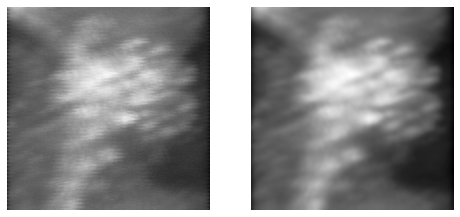

In [11]:
# Settings
## reference image
numRefImg = 600
locRefImg = round(np.max(imgStack, axis=1)['volumes [s]'].size/3)

# Generate reference image
refImg = np.mean(np.max(imgStack, axis=1)[locRefImg:locRefImg+numRefImg,:,:],axis=0)

from scipy.ndimage.filters import gaussian_filter
refImgFilt = gaussian_filter(refImg, sigma=2)

fig, axs = plt.subplots(1,2,figsize=(8,4))
axs[0].imshow(refImg,cmap='Greys_r', origin='lower')
axs[0].axis('off');
axs[1].imshow(refImgFilt,cmap='Greys_r', origin='lower')
axs[1].axis('off');

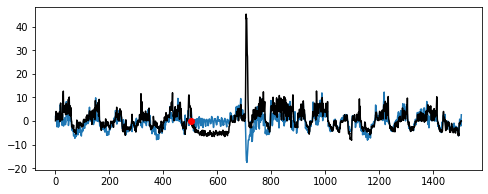

In [12]:
stackMPMC, shift = imp.motionCorrection(np.max(imgStack, axis=1), refImg, 20, 2)

fig, ax = plt.subplots(1,1,figsize=(8,3))
ax.plot(shift[0,:])
ax.plot(shift[1,:],'k')
ax.plot(locRefImg,0,'ro')

#### Apply estimated motion to 4d stack
We assume here that all planes in a volume at a given time moved together

In [13]:
stack4dMC = imp.applyShiftTo4Dstack(imgStack, shift)

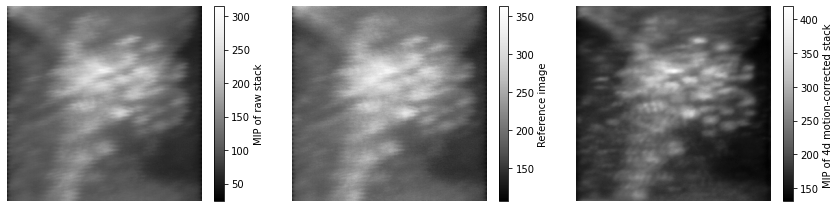

In [14]:
fig, axs = plt.subplots(1,3,figsize=(12,3))
cb = axs[0].imshow(stack.max(axis=1).mean(axis=0),cmap='Greys_r', origin='lower')
plt.colorbar(cb, ax=axs[0], label='MIP of raw stack')
axs[0].axis('off');
cb = axs[1].imshow(refImg,cmap='Greys_r', origin='lower')
plt.colorbar(cb, ax=axs[1], label='Reference image')
axs[1].axis('off');
cb = axs[2].imshow(stack4dMC.max(axis=1).mean(axis=0),cmap='Greys_r', origin='lower')
plt.colorbar(cb, ax=axs[2], label='MIP of 4d motion-corrected stack ')
axs[2].axis('off');
fig.tight_layout()

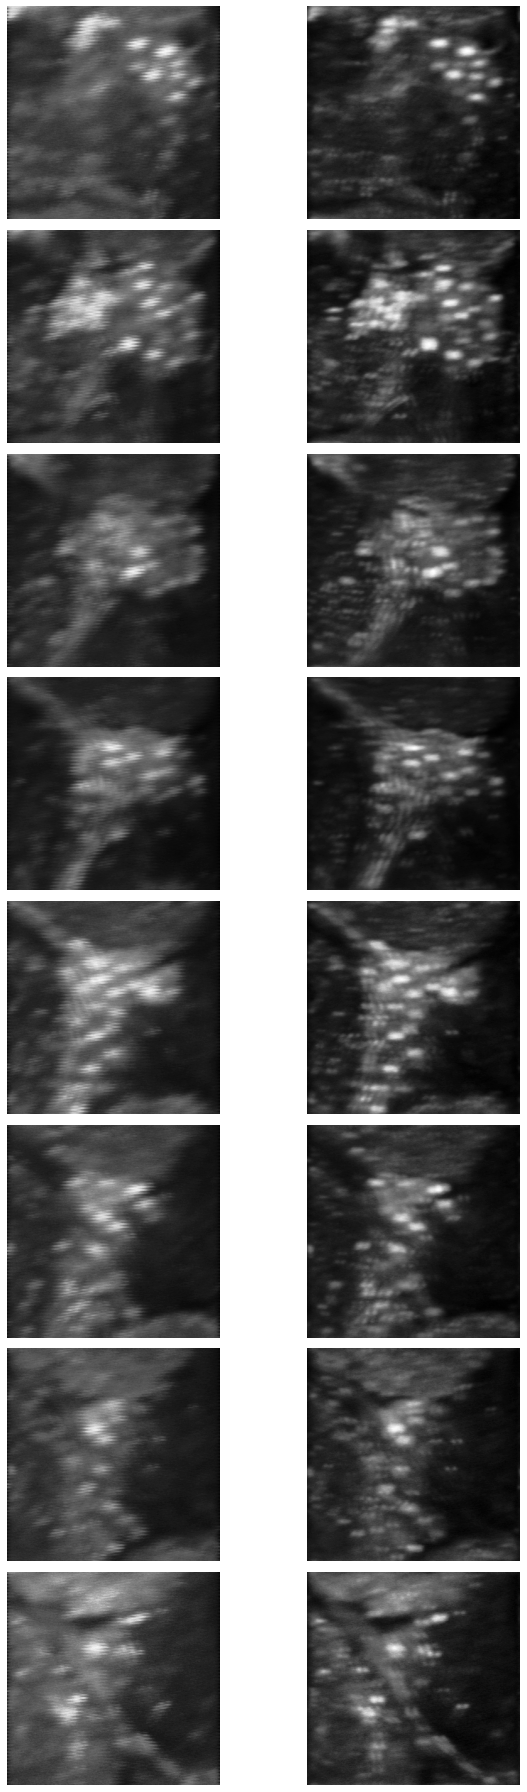

In [15]:
fig, ax = plt.subplots(stack4dMC["planes [µm]"].size,2, figsize=(10, 25))
for i in range(stack4dMC["planes [µm]"].size):
    ax[i,0].imshow(imgStack[:,i,:,:].mean(axis=0),cmap='Greys_r',origin='lower')
    ax[i,1].imshow(stack4dMC[:,i,:,:].mean(axis=0),cmap='Greys_r',origin='lower')
    ax[i,0].axis('off')
    ax[i,1].axis('off');
fig.tight_layout()
fig.savefig(saveDir+sep+'_'.join(['meanSignal_beforeAfterMC_',genotype, region, flyID, age, condition, trial])+'.pdf')

### Perform correlation analysis to get ROIs

#### (1) Compute DFF

In [16]:
# Settings
# filter DF/F trace with Savitzky-Golay filter
from scipy.signal import savgol_filter

# 3rd order, 7 frames
order = 3
window = 7

# Currently F_0 is estimated for the whole time series (ok, if time series is short)
baseLinePercent = 10
offset = 0.0001

(a) one plane

In [30]:
dffStackMC = np.zeros((stackMPMC.shape)) 
stackF0 = np.zeros((stackMPMC["xpix [µm]"].size,stackMPMC["ypix [µm]"].size)) 

filtStack = gaussian_filter(stackMPMC, sigma=[0,2,2])

filtF = savgol_filter(filtStack.astype('float'), window, order, axis=0)

# Estimate baseline
stackF0 = np.percentile(filtF, baseLinePercent, axis=0) + offset
stackF0[np.where(stackF0 == 0)[0]] += offset

# Compute dF/F_0 = (F_raw - F_0)/F_0
dffStackMC = (filtF - stackF0) / stackF0

dffMP = np.max(dffStackMC, axis=0)

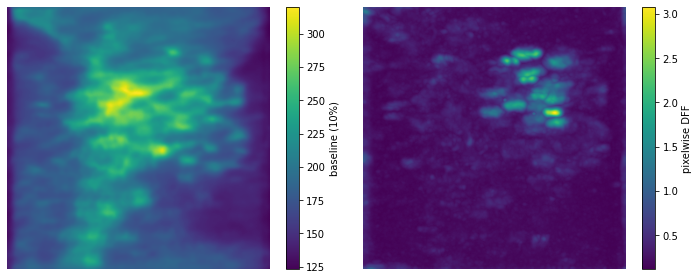

In [31]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
cb = ax[0].imshow(stackF0,cmap='viridis',origin='lower')#, vmin=0, vmax=10)
plt.colorbar(cb, ax=ax[0], label='baseline ({}%)'.format(baseLinePercent))
ax[0].axis('off')
cb = ax[1].imshow(dffMP,cmap='viridis',origin='lower')#, vmin=0, vmax=10)
plt.colorbar(cb, ax=ax[1], label='pixelwise DFF')
ax[1].axis('off')
fig.tight_layout()
#viewerdff = napari.view_image(dffStackMC)

(b) volume

In [33]:
dffStack4dMC = np.zeros((stack4dMC.shape)) 
stackF0vol = np.zeros((stack4dMC["planes [µm]"].size, stackMPMC["xpix [µm]"].size, stackMPMC["ypix [µm]"].size)) 

for p in range(stack4dMC["planes [µm]"].size):
    filtStack = gaussian_filter(stack4dMC[{'planes [µm]': p}].squeeze(), sigma=[0,2,2])

    filtF = savgol_filter(filtStack.astype('float'), window, order, axis=0)

    # Estimate baseline
    stackF0vol[p,:,:] = np.percentile(filtF, baseLinePercent, axis=0) + offset
    stackF0vol[p,np.where(stackF0vol[p,:,:] == 0)[0]] += offset

    # Compute dF/F_0 = (F_raw - F_0)/F_0
    dffStack4dMC[:,p,:,:] = (filtF - stackF0vol[p,:,:]) / stackF0vol[p,:,:]

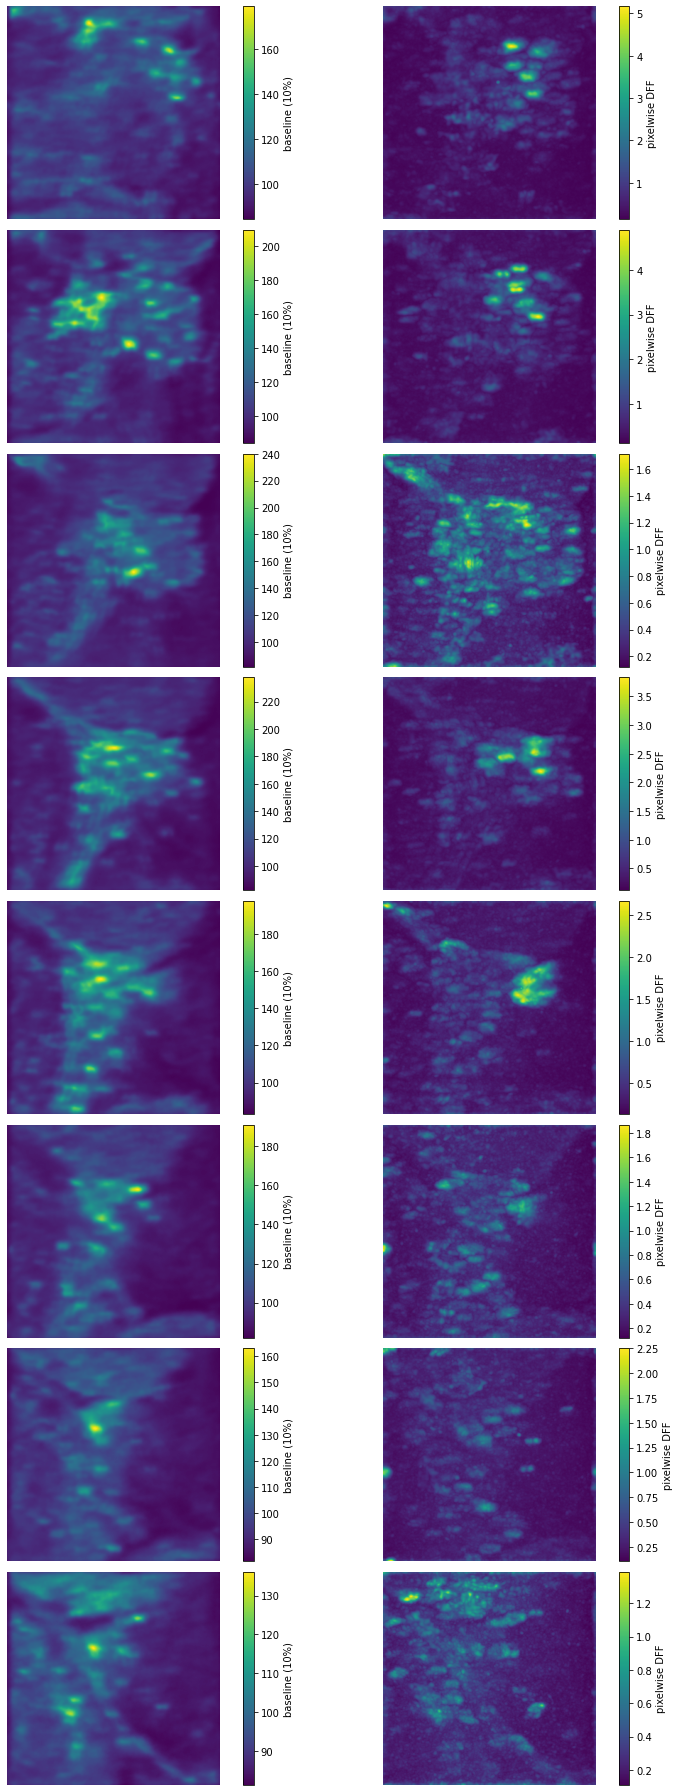

In [34]:
fig, ax = plt.subplots(stack4dMC["planes [µm]"].size,2,figsize=(12,25))
for i in range(stack4dMC["planes [µm]"].size):
    cb = ax[i,0].imshow(stackF0vol[i,:,:],cmap='viridis',origin='lower')#, vmin=0, vmax=10)
    plt.colorbar(cb, ax=ax[i,0], label='baseline ({}%)'.format(baseLinePercent))
    ax[i,0].axis('off')
    
    cb = ax[i,1].imshow(np.max(dffStack4dMC[:,i,:,:],axis=0),cmap='viridis',origin='lower')#, vmin=0, vmax=10)
    plt.colorbar(cb, ax=ax[i,1], label='pixelwise DFF')
    ax[i,1].axis('off')
    
fig.tight_layout()
fig.savefig(saveDir+sep+'_'.join(['DFFperPlane_beforeAfterMC_',genotype, region, flyID, age, condition, trial])+'.pdf')

In [85]:
viewerdff1 = napari.view_image(dffStack4dMC)

#### (2) Define regions on which to perform clustering
Mark the area that should be considered with the napari labeling tool in a layer named "mask".

(a) Single plane mask for max projection

In [35]:
viewer = napari.view_image(refImgFilt)

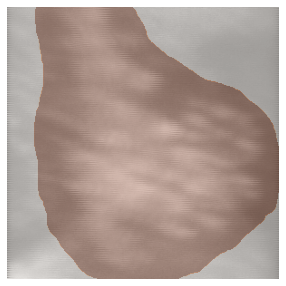

In [36]:
# you can draw a mask:
mask = viewer.layers["mask"]
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.imshow(refImg,cmap='Greys_r', vmin=0, origin='lower')
ax.axis('off');
ax.imshow(mask.data, cmap='Oranges', alpha=0.3)
fig.savefig(saveDir+sep+'_'.join(['mask',genotype, region, flyID, age, condition, trial])+'.pdf')

(b) 3D mask for volume processing

In [37]:
refStack = stack4dMC[0,:,:,:]
for i in range(stack4dMC["planes [µm]"].size):
    refStack[i,:,:] = stack4dMC[:,i,:,:].mean(axis=0)
    
viewer3D = napari.view_image(refStack)

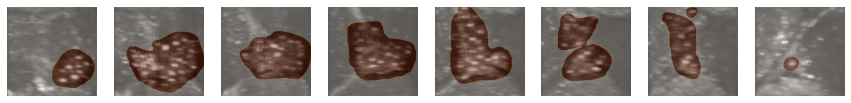

In [38]:
mask3D = viewer3D.layers["mask"]

fig, ax = plt.subplots(1,stack4dMC["planes [µm]"].size, figsize=(15,4))
for i in range(stack4dMC["planes [µm]"].size):
    ax[i].imshow(refStack[i,:,:],cmap='Greys_r',origin='lower')  
    ax[i].axis('off');
    ax[i].imshow(mask3D.data[i,:,:], cmap='Oranges', alpha=0.35)
    
fig.savefig(saveDir+sep+'_'.join(['mask3D',genotype, region, flyID, age, condition, trial])+'.pdf')

#### (3) Perform clustering on pixels in mask

TODO: Check time axis generatiton

In [39]:
# Settings
from sklearn.cluster import KMeans

nclst = 10 # 4 for FBt

One plane

In [80]:
dffMask = np.logical_and(mask.data>0, np.std(dffStackMC, axis=0) > 0.08)
toClust = dffStackMC[:,dffMask]

kmeans = KMeans(n_clusters=nclst)
kmeans.fit(toClust.T)

KMeans(n_clusters=10)

In [81]:
kmlabs = kmeans.predict(toClust.T)
centroids = kmeans.cluster_centers_

In [82]:
myClstMap = 'tab20b_r'
cNorm  = colors.Normalize(vmin=1, vmax=nclst)
clstCMap = plt.cm.ScalarMappable(norm=cNorm,cmap=myClstMap)

time = np.linspace(0, stackMPMC.shape[0]/basicMetadat['fpv'], stackMPMC.shape[0])

kmlabsImg = np.nan*np.ones(dffMask.shape)

kmlabsImg[dffMask] = kmlabs

ypos = np.repeat(np.arange(dffMask.shape[0]),dffMask.shape[1]).reshape(dffMask.shape)
yPosClust = np.zeros(nclst)
for i in range(nclst):
    yPosClust[i] = dffMask.shape[0]-np.median(ypos[kmlabsImg==i])
    
centroidPerm = np.argsort(yPosClust)#
centroids2Plot = centroids[centroidPerm,:]

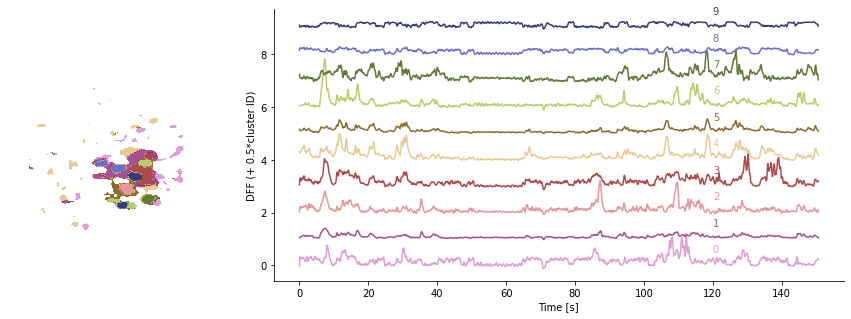

In [83]:
fig, axs = plt.subplots(1,2,figsize=(15,5), gridspec_kw={'width_ratios':[1,3]})

axs[0].imshow(kmlabsImg,cmap=myClstMap,origin='upper')
axs[0].axis('off')

for i in range(nclst):
    axs[1].plot(time,centroids2Plot[i]+i, color=clstCMap.to_rgba(i+1))
    axs[1].text(120,+i+.5,str(i),color=clstCMap.to_rgba(i+1))
axs[1].set_xlabel('Time [s]')
axs[1].set_ylabel('DFF (+ 0.5*cluster ID)')
myAxisTheme(axs[1])

fig.savefig(saveDir+sep+'_'.join(['ROIcluster_kn{}'.format(nclst),genotype, region, flyID, age, condition, trial])+'.pdf')

<ipython-input-84-345e5cd425fc>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axs.pcolor(time,np.arange(0,nclst),centroids2Plot,cmap='Blues', edgecolors='face')


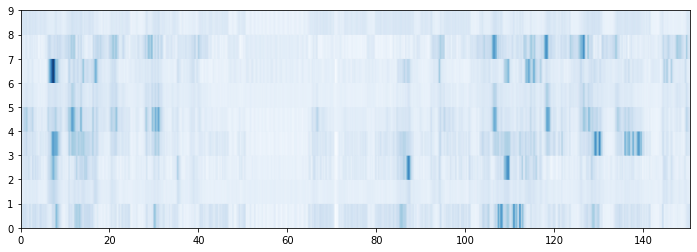

In [84]:
fig, axs = plt.subplots(1,1,figsize=(12,4))

axs.pcolor(time,np.arange(0,nclst),centroids2Plot,cmap='Blues', edgecolors='face')
fig.savefig(saveDir+sep+'_'.join(['ROIcluster_kn{}_DFFreordered'.format(nclst),genotype, region, flyID, age, condition, trial])+'.pdf')

Volume

In [95]:
nclst = 10

dffMask = np.logical_and(mask3D.data>0, np.std(dffStack4dMC, axis=0) > 0.08)
toClust = dffStack4dMC[:,dffMask]

kmeans = KMeans(n_clusters=nclst)
kmeans.fit(toClust.T)

KMeans(n_clusters=10)

In [96]:
kmlabs = kmeans.predict(toClust.T)
centroids = kmeans.cluster_centers_

In [97]:
myClstMap = 'tab20b_r'
cNorm  = colors.Normalize(vmin=1, vmax=nclst)
clstCMap = plt.cm.ScalarMappable(norm=cNorm,cmap=myClstMap)

time = np.linspace(0, stackMPMC.shape[0]/basicMetadat['fpv'], stackMPMC.shape[0])

<ipython-input-98-babb09540f4d>:22: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


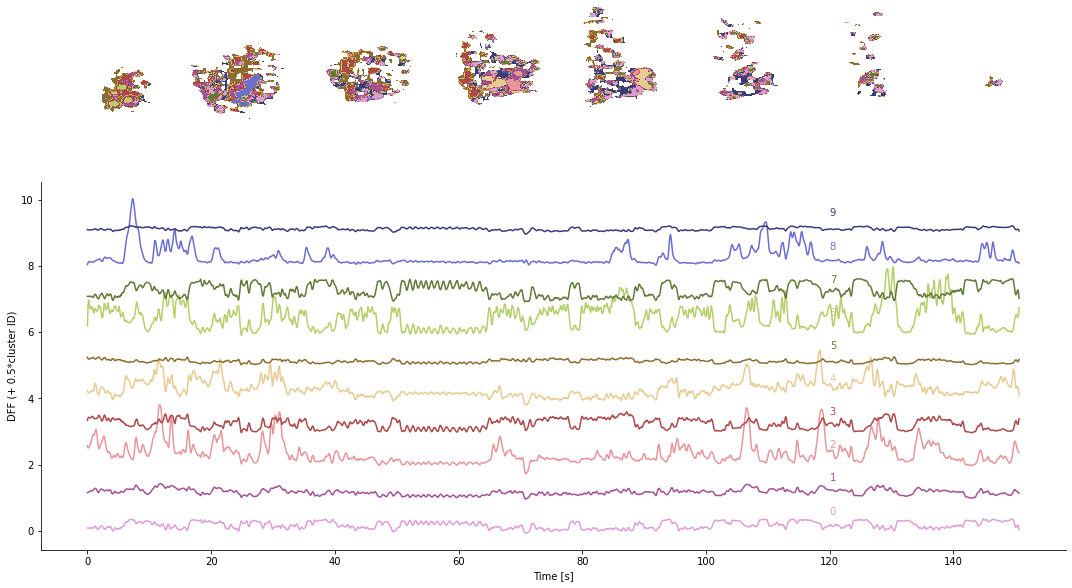

In [98]:
kmlabsImg = np.nan*np.ones(mask3D.data.shape)

kmlabsImg[dffMask] = kmlabs

fig = plt.figure(constrained_layout=True,figsize=(15,10))
#import matplotlib.gridspec as gridspec
gs  = fig.add_gridspec(2,stack4dMC["planes [µm]"].size)

for p in range(stack4dMC["planes [µm]"].size):
    ax = fig.add_subplot(gs[0,p])
    ax.imshow(kmlabsImg[p,:,:],cmap=myClstMap,origin='upper')
    ax.axis('off')

ax = fig.add_subplot(gs[1,:])
for i in range(nclst):
    ax.plot(time,centroids[i]+i, color=clstCMap.to_rgba(i+1))
    ax.text(120,+i+.5,str(i),color=clstCMap.to_rgba(i+1))
ax.set_xlabel('Time [s]')
ax.set_ylabel('DFF (+ 0.5*cluster ID)')
#ax.set_ylim(0, 1+nclst)
myAxisTheme(ax)
fig.tight_layout()
fig.savefig(saveDir+sep+'_'.join(['ROIcluster3D_kn{}'.format(nclst),genotype, region, flyID, age, condition, trial])+'.pdf')

<ipython-input-99-e68076497607>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axs.pcolor(time,np.arange(0,nclst),centroids2Plot,cmap='Blues', edgecolors='face')


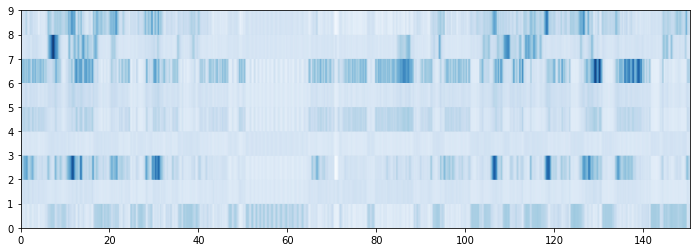

In [99]:
centroidPerm = np.argsort(yPosClust)#
centroids2Plot = centroids[centroidPerm,:]

fig, axs = plt.subplots(1,1,figsize=(12,4))

axs.pcolor(time,np.arange(0,nclst),centroids2Plot,cmap='Blues', edgecolors='face')
fig.savefig(saveDir+sep+'_'.join(['ROIcluster3D_kn{}_DFFreordered'.format(nclst),genotype, region, flyID, age, condition, trial])+'.pdf')